In [94]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('..')
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from genetic.utils import calculate_inertia, get_cluster_distribution
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv('../data/clean_data/clean_data.csv')
data.head()

,duration_ms,loudness,tempo,valence,acousticness,danceability,energy
0,0.403695,0.451467,0.178779,0.963,0.732,0.819,0.341
1,0.483304,0.557378,0.412301,0.165,0.967,0.275,0.309
2,0.366304,0.530943,0.421576,0.253,0.957,0.418,0.193
3,0.983312,0.449265,0.529827,0.196,0.579,0.697,0.346
4,0.346890,0.514234,0.210284,0.406,0.996,0.518,0.203


# Preliminary logs

Disclaimer: I forgot to add to the logs the fitness (which is the inertia)...<br>
At least I've logged the best representations, so we can calculate the inertia and check!

In [6]:
with open('../data/logs/02-06-2024--00-54-17--ALGO_SELECTION.pkl', 'rb') as f:
    p_logs = pickle.load(f)

p_logs.keys()

dict_keys(['time', 'loop_time', 'best', 'selection', 'xo', 'mutation'])

In this preliminary run, we have ran 5 distinct populations for each combination of available Crossover, Selection and Mutation.<br>

In [7]:
df_pre = pd.DataFrame().from_dict(p_logs)
df_pre.head()

,time,loop_time,best,selection,xo,mutation
0,3.470610,"[0.2947573661804199, 0.30557823181152344, 0.26...","[[0.5144546499694906, 0.5144546499694906, 0.51...",tournament_sel,single_centroid_crossover,coordinate_mutation
1,4.519453,"[0.2886185646057129, 0.30994582176208496, 0.26...","[[0.36756888660184484, 0.14730487211706988, 0....",tournament_sel,single_centroid_crossover,coordinate_mutation
2,4.807515,"[0.30596256256103516, 0.31203770637512207, 0.2...","[[0.46964896500868103, 0.7433423008554427, 0.6...",tournament_sel,single_centroid_crossover,coordinate_mutation
3,5.567898,"[0.29167604446411133, 0.31197047233581543, 0.2...","[[0.6323033431528889, 0.6323033431528889, 0.63...",tournament_sel,single_centroid_crossover,coordinate_mutation
4,6.022527,"[0.30576229095458984, 0.3100917339324951, 0.26...","[[0.5560835084138883, 0.5560835084138883, 0.55...",tournament_sel,single_centroid_crossover,coordinate_mutation


In [8]:
df_pre.loc[:, 'inertia'] = df_pre.best.apply(lambda x: calculate_inertia(x, data))
df_pre.head()

,time,loop_time,best,selection,xo,mutation,inertia
0,3.470610,"[0.2947573661804199, 0.30557823181152344, 0.26...","[[0.5144546499694906, 0.5144546499694906, 0.51...",tournament_sel,single_centroid_crossover,coordinate_mutation,43935.198544
1,4.519453,"[0.2886185646057129, 0.30994582176208496, 0.26...","[[0.36756888660184484, 0.14730487211706988, 0....",tournament_sel,single_centroid_crossover,coordinate_mutation,37475.419456
2,4.807515,"[0.30596256256103516, 0.31203770637512207, 0.2...","[[0.46964896500868103, 0.7433423008554427, 0.6...",tournament_sel,single_centroid_crossover,coordinate_mutation,37954.473840
3,5.567898,"[0.29167604446411133, 0.31197047233581543, 0.2...","[[0.6323033431528889, 0.6323033431528889, 0.63...",tournament_sel,single_centroid_crossover,coordinate_mutation,46519.133218
4,6.022527,"[0.30576229095458984, 0.3100917339324951, 0.26...","[[0.5560835084138883, 0.5560835084138883, 0.55...",tournament_sel,single_centroid_crossover,coordinate_mutation,41792.266737


## Time of execution

<font color='red'>There were 18 batches of 5 populations, each batch with a different combination of selection, crossover and mutation algorithms. In total 84/85 runs were succesful.</font><br>
<br>
All the runs were made in parallel with a 13th Gen i9 CPU.<br>
The bottleneck was the **Crossover** step in PNN and pairwise algorithms. Due to its iterative nature of calculating new centroids and merging the closest ones, no parallelism could be implemented in this step.<br>
As the crossover algorithm was the most impactful parameter, we've decided to perform the bulk of this analysis taking it as the main actor.<br>
<br>
It is worth mentioning that we have coded an "early stopping" of sorts. And if, after 10 generations, the fitness didn't improve, the algorithm stops.

In [9]:
df_pre.loc[:, 'loop_time_mean'] = df_pre.loop_time.apply(lambda x: np.mean(x))
df_pre.loc[:, 'gens_to_converge'] = df_pre.loop_time.apply(lambda x: len(x) - 10)

In [10]:
round_mean = lambda x: int(np.mean(x))
round_mean.__name__ = 'mean'

df_pre.groupby(['xo'])[['time', 'loop_time_mean', 'gens_to_converge']].agg({'time': ['mean', 'std'], 'loop_time_mean': ['mean', 'std'], 'gens_to_converge': round_mean})

time            loop_time_mean            \
                                 mean        std           mean       std   
xo                                                                          
PNN                        352.776615  63.808783      22.735858  3.662518   
pairwise_crossover         106.016421  62.905720       4.387692  2.003210   
single_centroid_crossover    4.278971   1.230531       0.269855  0.005633   

                          gens_to_converge  
                                      mean  
xo                                          
PNN                                      5  
pairwise_crossover                      14  
single_centroid_crossover                5

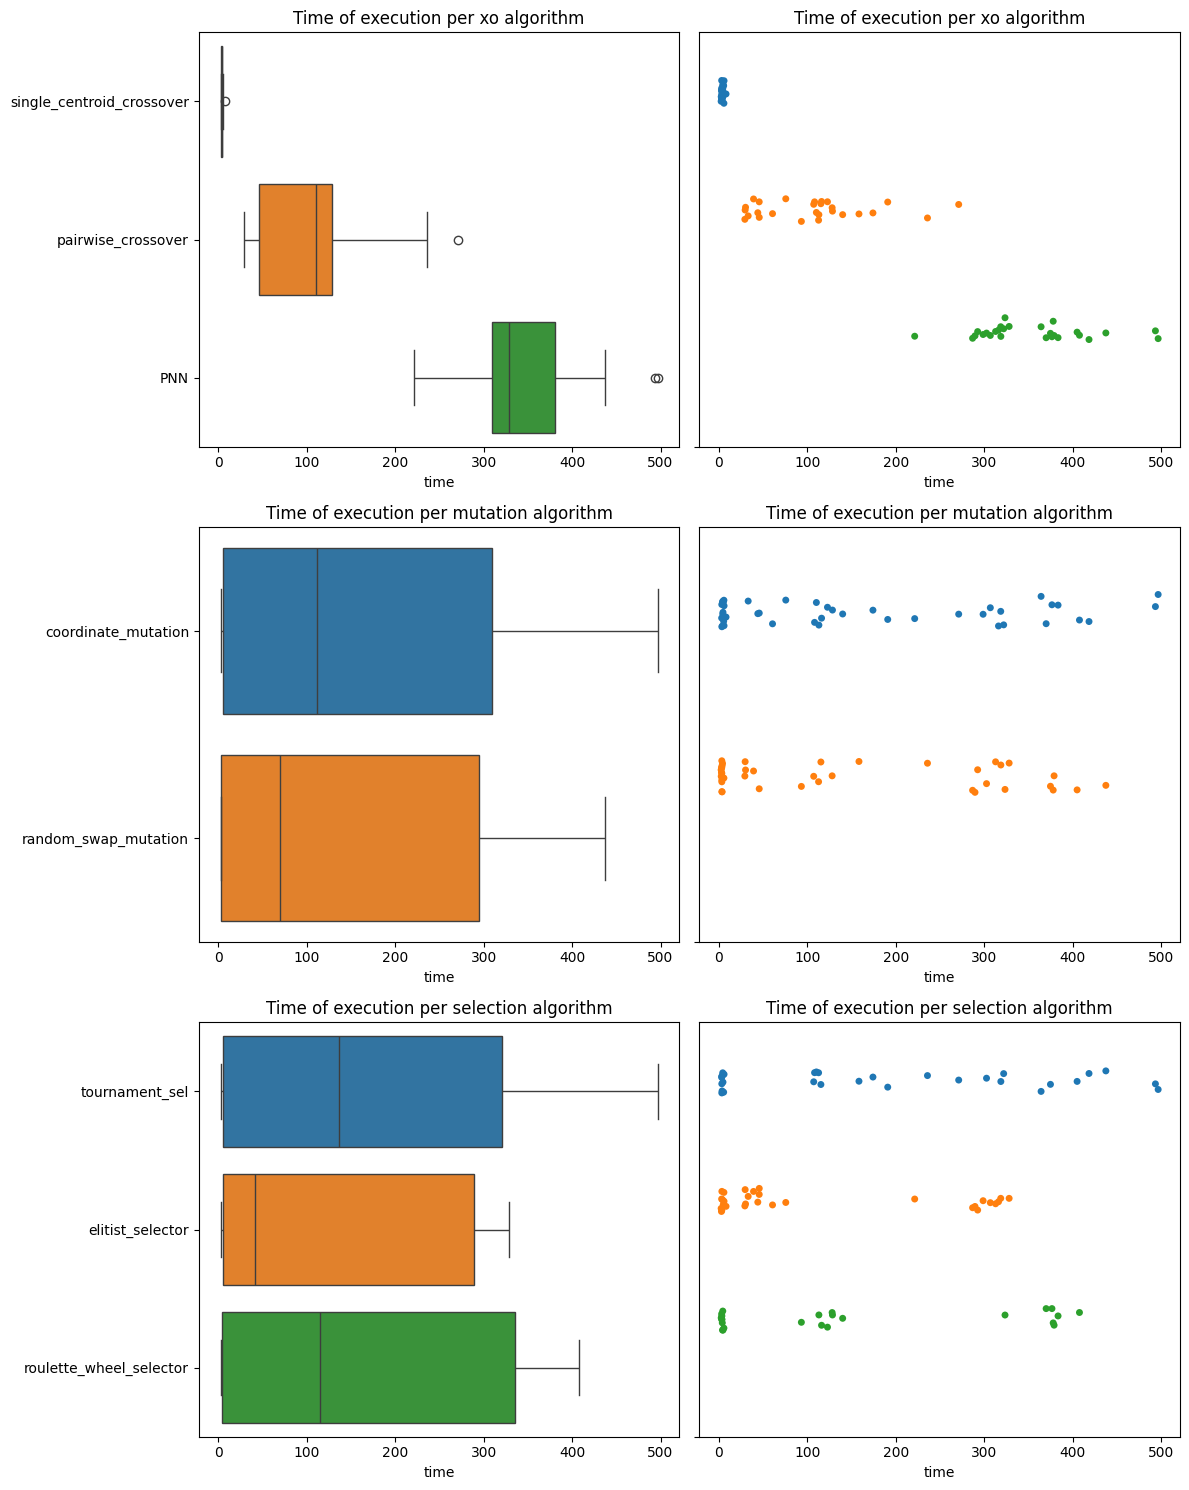

In [88]:
fig, axs = plt.subplots(3, 2, figsize=(12,15))
for algo, ax in zip(['xo', 'mutation', 'selection'], axs):
    sns.boxplot(df_pre, x='time', y=algo, ax=ax[0], hue=algo)
    sns.stripplot(df_pre, x='time', y=algo, ax=ax[1], hue=algo)
    
    ax[0].set_title(f'Time of execution per {algo} algorithm');
    ax[1].set_title(f'Time of execution per {algo} algorithm')

    ax[0].set_ylabel('')
    ax[1].set_ylabel('')

    ax[1].set_yticks('')

plt.tight_layout();

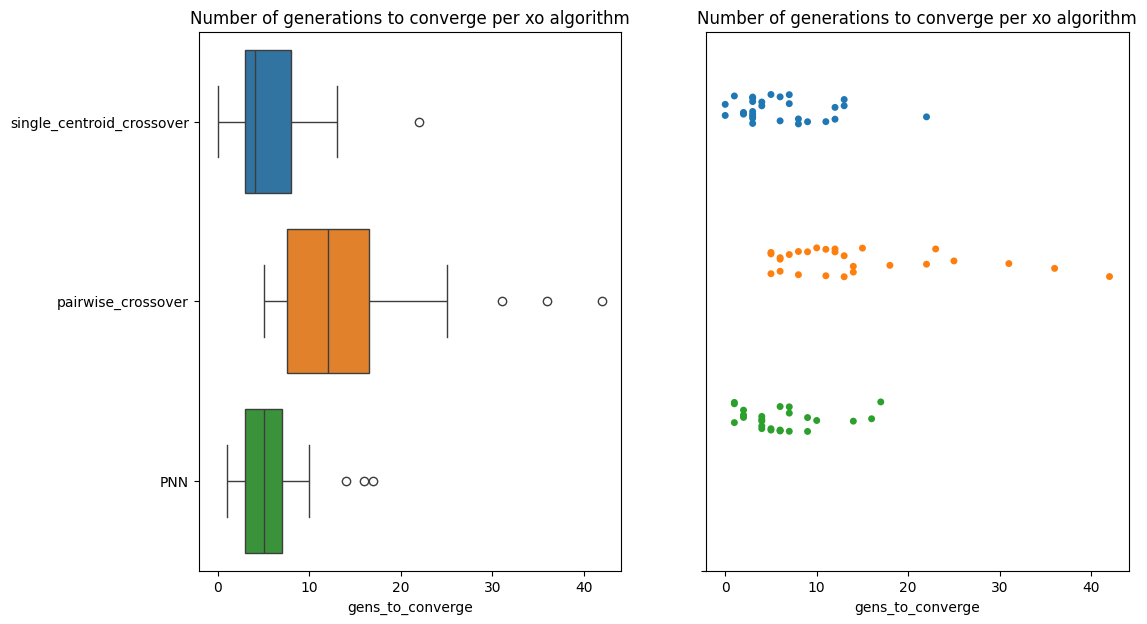

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(df_pre, x='gens_to_converge', y='xo', ax=axs[0], hue='xo');
sns.stripplot(df_pre, x='gens_to_converge', y='xo', ax=axs[1], hue='xo')

axs[0].set_title('Number of generations to converge per xo algorithm')
axs[1].set_title('Number of generations to converge per xo algorithm')

axs[0].set_ylabel('')
axs[1].set_ylabel('')

axs[1].set_yticks('');

## Metrics

In [60]:
df_pre.groupby(['xo', 'selection', 'mutation'])[['inertia']].mean().sort_values('inertia')

inertia
xo                        selection               mutation                          
PNN                       roulette_wheel_selector random_swap_mutation  24628.276423
                                                  coordinate_mutation   24651.107880
                          tournament_sel          coordinate_mutation   27946.963038
                          elitist_selector        coordinate_mutation   28824.947380
                          tournament_sel          random_swap_mutation  29996.630264
                          elitist_selector        random_swap_mutation  31275.318396
pairwise_crossover        roulette_wheel_selector coordinate_mutation   32618.126185
                          tournament_sel          coordinate_mutation   34563.399489
                                                  random_swap_mutation  34778.850986
                          roulette_wheel_selector random_swap_mutation  36891.065124
single_centroid_crossover tournament_sel          coordinate_mutation   41535.298359
pairwise_crossover        elitist_selector        random_swap_mutation  41932.201667
single_centroid_crossover elitist_selector        coordinate_mutation   46524.588271
                          roulette_wheel_selector coordinate_mutation   48666.425775
pairwise_crossover        elitist_selector        coordinate_mutation   49760.273652
single_centroid_crossover tournament_sel          random_swap_mutation  50482.680424
                          roulette_wheel_selector random_swap_mutation  54451.409660
                          elitist_selector        random_swap_mutation  55391.328058

<font size=4 color='red'>ALL the best results were using PNN crossover.</font>

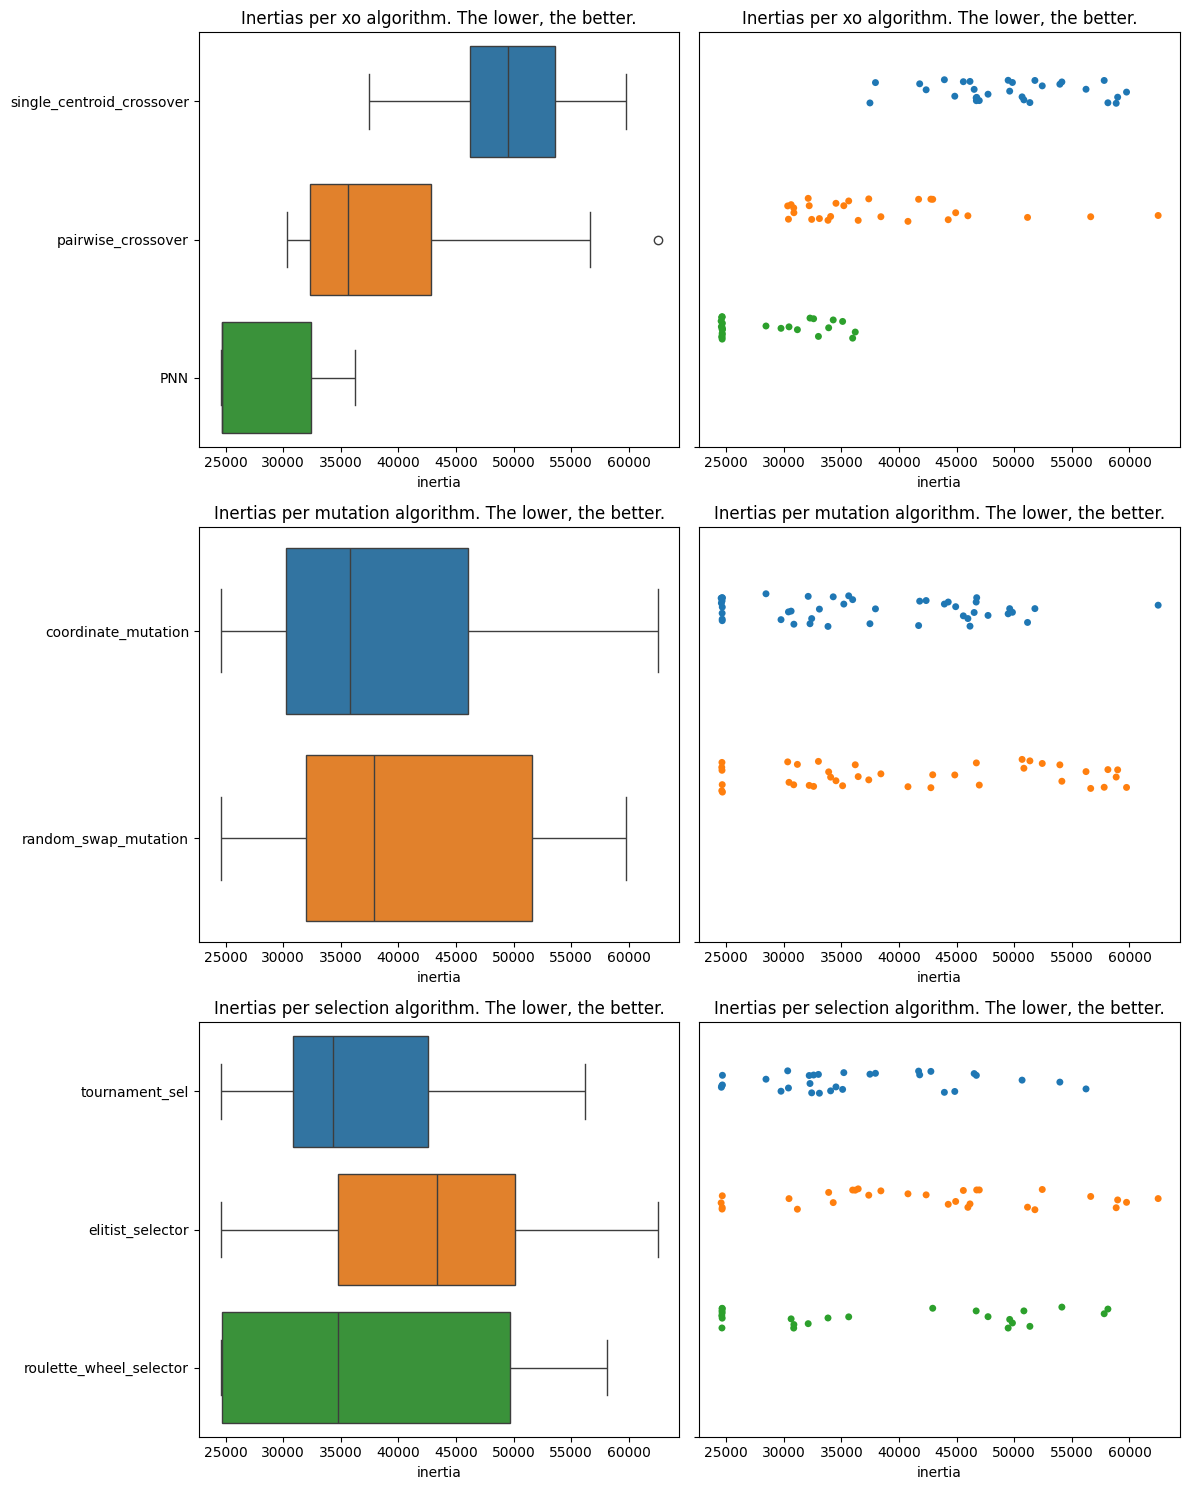

In [104]:
fig, axs = plt.subplots(3, 2, figsize=(12,15))
for algo, ax in zip(['xo', 'mutation', 'selection'], axs):
    sns.boxplot(df_pre, x='inertia', y=algo, ax=ax[0], hue=algo)
    sns.stripplot(df_pre, x='inertia', y=algo, ax=ax[1], hue=algo)
    
    ax[0].set_title(f'Inertias per {algo} algorithm. The lower, the better.');
    ax[1].set_title(f'Inertias per {algo} algorithm. The lower, the better.')

    ax[0].set_ylabel('')
    ax[1].set_ylabel('')

    ax[1].set_yticks('')

plt.tight_layout();

### Is PNN worth?

If the main aim is to get to the best value possible, using GAs, yes.<br>
If time is a constrain, let's try to greate a metric to measure it.

In [122]:
PNN_inertia = df_pre.loc[df_pre.xo == 'PNN', 'inertia']
PNN_time = df_pre.loc[df_pre.xo == 'PNN', 'time']

pairwise_inertia = df_pre.loc[df_pre.xo == 'pairwise_crossover', 'inertia']
pairwise_time = df_pre.loc[df_pre.xo == 'pairwise_crossover', 'time']

In [126]:
1 - (PNN_inertia.mean() / pairwise_inertia.mean())

0.2680666010667416

In [127]:
PNN_time.mean() / pairwise_time.mean()

3.3275657780992325

<font color='red'>The PNN improves the results in ~27%, but takes 3 times more to give a result, comparing to pairwise crossover.</font>

# Final logs with inertia as fitness

In [22]:
with open('../data/logs/02-06-2024--10-57-50--FULL_RUN.pkl', 'rb') as f:
    f_logs = pickle.load(f)

f_logs.keys()

dict_keys(['time', 'loop_time', 'best', 'selection', 'xo', 'mutation'])

In [24]:
df_final = pd.DataFrame().from_dict(f_logs)
df_final.head()

,time,loop_time,best,selection,xo,mutation
0,238.300086,"[25.65622878074646, 22.744904279708862, 18.439...","[[0.572482795589442, 0.616151106892431, 0.5589...",elitist_selector,PNN,random_swap_mutation
1,270.374340,"[24.326478719711304, 20.38233518600464, 25.697...","[[0.399085957885212, 0.4692869844803897, 0.519...",elitist_selector,PNN,random_swap_mutation
2,273.935669,"[22.499300241470337, 20.722336292266846, 25.70...","[[0.39449645693708185, 0.4698947680997421, 0.5...",elitist_selector,PNN,random_swap_mutation
3,349.308173,"[28.89338779449463, 21.612872838974, 24.201088...","[[0.5153669185295041, 0.5920158404245034, 0.53...",elitist_selector,PNN,random_swap_mutation
4,369.804610,"[25.507760286331177, 24.475112199783325, 16.53...","[[0.5096078375692251, 0.5995223796014387, 0.54...",elitist_selector,PNN,random_swap_mutation


In [25]:
df_final.loc[:, 'inertia'] = df_final.best.apply(lambda x: calculate_inertia(x, data))
df_final.head()

,time,loop_time,best,selection,xo,mutation,inertia
0,238.300086,"[25.65622878074646, 22.744904279708862, 18.439...","[[0.572482795589442, 0.616151106892431, 0.5589...",elitist_selector,PNN,random_swap_mutation,24594.332973
1,270.374340,"[24.326478719711304, 20.38233518600464, 25.697...","[[0.399085957885212, 0.4692869844803897, 0.519...",elitist_selector,PNN,random_swap_mutation,34687.608403
2,273.935669,"[22.499300241470337, 20.722336292266846, 25.70...","[[0.39449645693708185, 0.4698947680997421, 0.5...",elitist_selector,PNN,random_swap_mutation,24582.735565
3,349.308173,"[28.89338779449463, 21.612872838974, 24.201088...","[[0.5153669185295041, 0.5920158404245034, 0.53...",elitist_selector,PNN,random_swap_mutation,30109.687912
4,369.804610,"[25.507760286331177, 24.475112199783325, 16.53...","[[0.5096078375692251, 0.5995223796014387, 0.54...",elitist_selector,PNN,random_swap_mutation,24545.565633


## Time of execution

<font color='red'>There were 10 batches of 5 populations, totalling 50 independent runs.</font><br>
All the runs were made in parallel with a 13th Gen i9 CPU.<br>
The bottleneck was the **Crossover** step, most probably the application of Scikit-learn's KMeans. Its implementation allocates extra space in the memory and locks more than 1 thread. This could be observed by monitoring the CPU usage<br>
<br>
It is worth mentioning that we have coded an "early stopping" of sorts. And if, after 10 generations, the fitness didn't improve, the algorithm stops.

### Total time

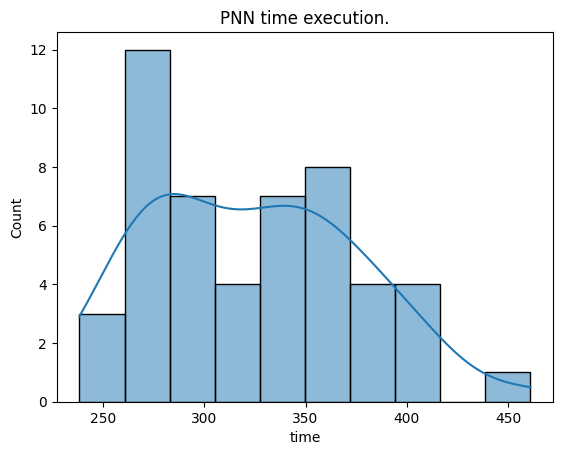

In [35]:
sns.histplot(df_final['time'], kde=True, bins=10)
plt.title('PNN time execution.');

In [66]:
mean_time_of_execution = df_final.time.mean()

In [67]:
print(f'Each batch of 5 population took, in average {mean_time_of_execution:.2f} seconds.')

Each batch of 5 population took, in average 324.25 seconds.


The parallel execution approach paid off. By running the population individually, each individual run was taking roughly 120 seconds to complete.

In [68]:
print(f'The improvement by running in parallel was {(1- (mean_time_of_execution / (5*120)))*100:.2f}%')

The improvement by running in parallel was 45.96%


In [27]:
print(f'The estimated total time of execution (for 50 runs) was: {mean_time_of_execution*10:.2f} seconds.')

The estimated total time of execution (for 50 runs) was: 3242.50 seconds.


### Loop time

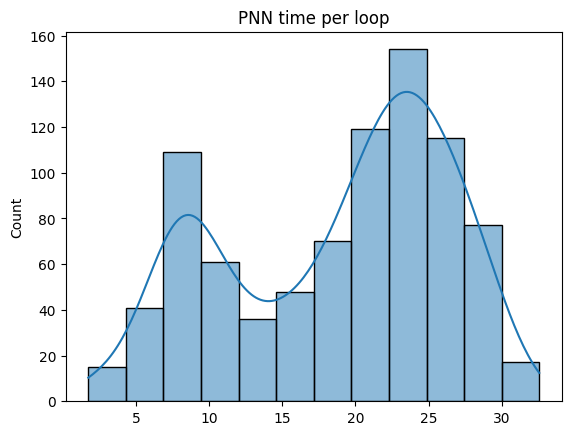

In [42]:
t = []
df_final.loop_time.apply(lambda x: t.extend(x))

sns.histplot(t, kde=True)
plt.title('PNN time per loop');

In [43]:
loop_time_mean = df_final.loop_time.apply(lambda x: np.mean(x)).mean()

In [44]:
print(f'The mean time of execution of each generation loop was {loop_time_mean:.2f} seconds.')

The mean time of execution of each generation loop was 19.64 seconds.


In [45]:
loop_time_std = df_final.loop_time.apply(lambda x: np.std(x)).mean()

In [46]:
print(f'The standard deviation of time of execution of the generation loop was {loop_time_std:.2f} seconds.')

The standard deviation of time of execution of the generation loop was 6.30 seconds.


### Number of generations to converge

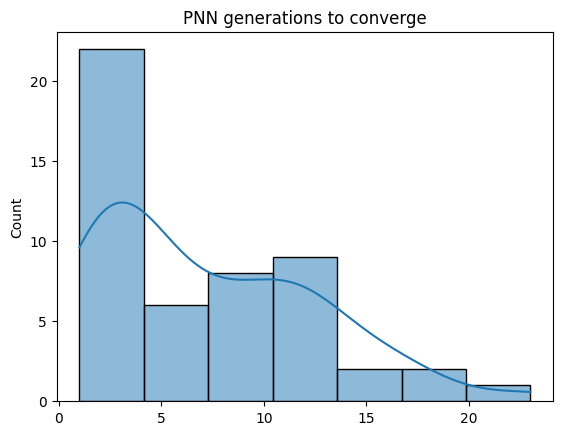

In [50]:
g = []
df_final.loop_time.apply(lambda x: g.append(len(x) - 10))

sns.histplot(g, kde=True)
plt.title('PNN generations to converge');

In [47]:
print(f'The algorithm took, in average, {df_final.loop_time.apply(lambda x: len(x) - 10).mean():.0f} generations to converge.')

The algorithm took, in average, 7 generations to converge.


## Metrics

### Best solution found

In [51]:
best = df_final[df_final.inertia == df_final.inertia.min()]
best_inertia = best.inertia.iloc[0]
best_centroids = best.best.iloc[0]
best_generations_to_converge = best.loop_time.apply(lambda x: len(x) - 10).iloc[0]

In [52]:
print(f'The best inertia was: {best_inertia:.2f}.')

The best inertia was: 24533.45.


In [93]:
print(f'The best run took {best_generations_to_converge} generations to converge.')

The best run took 6 generations to converge.


In [97]:
get_cluster_distribution(best_centroids, data)

labels
1    0.273422
2    0.260433
3    0.242361
0    0.223783
Name: proportion, dtype: float64

In [103]:
best_centroids

array([[0.56977874, 0.60622711, 0.55121396, 0.35920552, 0.12939079,
        0.51391685, 0.66755455],
       [0.51063327, 0.59817511, 0.53989838, 0.76862631, 0.16313677,
        0.65843156, 0.70148711],
       [0.40361735, 0.47195815, 0.52920241, 0.72225111, 0.76733847,
        0.60911294, 0.39902535],
       [0.48486117, 0.34432539, 0.44299391, 0.28710029, 0.86167361,
        0.41389669, 0.21086879]])

### Dispersion metrics

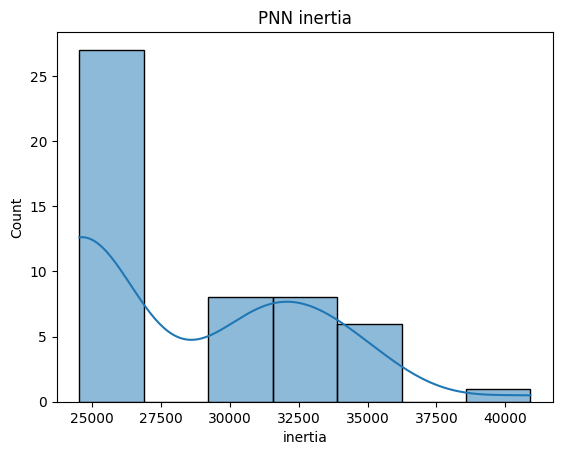

In [56]:
sns.histplot(df_final.inertia, kde=True)
plt.title('PNN inertia');

In [57]:
worst_inertia = df_final.inertia.max()
mean_inertia = df_final.inertia.mean()
std_inertia = df_final.inertia.std()

In [58]:
print(f'The worst result was: {worst_inertia:.2f}.')
print(f'The mean inertia was: {mean_inertia:.2f}.')
print(f'The inertia standard deviation was: {std_inertia:.2f}.')

The worst result was: 40909.98.
The mean inertia was: 28317.25.
The inertia standard deviation was: 4387.65.


# Final logs with inertia as fitness

In [59]:
with open('../data/logs/03-06-2024--04-41-17--FULL_RUN.pkl', 'rb') as f:
    f2_logs = pickle.load(f)

f2_logs.keys()

dict_keys(['time', 'loop_time', 'best', 'selection', 'xo', 'mutation', 'fitness', 'inertia'])

In [60]:
df_final2 = pd.DataFrame().from_dict(f2_logs)
df_final2.head()

,time,loop_time,best,selection,xo,mutation,fitness,inertia
0,342.709774,"[36.888277530670166, 27.17549753189087, 26.863...","[[0.4802100858993111, 0.3389978444540261, 0.43...",elitist_selector,PNN,random_swap_mutation,2218.850624,24612.832537
1,450.045023,"[34.70701336860657, 31.639452695846558, 29.209...","[[0.570433381767931, 0.6095414548517682, 0.555...",elitist_selector,PNN,random_swap_mutation,2209.272680,24512.874879
2,457.623981,"[34.2757613658905, 34.65230989456177, 36.99809...","[[0.5143237161791208, 0.6013512878256049, 0.54...",elitist_selector,PNN,random_swap_mutation,2218.223597,24606.685736
3,463.501951,"[34.660582542419434, 29.889888286590576, 33.11...","[[0.4773074224465136, 0.3442440187742203, 0.44...",elitist_selector,PNN,random_swap_mutation,2213.255551,24553.446104
4,501.754071,"[30.232518911361694, 27.950531721115112, 27.88...","[[0.5063406746973785, 0.5889850570575286, 0.53...",elitist_selector,PNN,random_swap_mutation,2213.642003,24557.986089


## Time of execution

<font color='red'>There were 10 batches of 5 populations, totalling 50 independent runs.</font><br>
All the runs were made in parallel with a 13th Gen i9 CPU.<br>
The bottleneck was the **Crossover** step, most probably the application of Scikit-learn's KMeans. Its implementation allocates extra space in the memory and locks more than 1 thread. This could be observed by monitoring the CPU usage<br>
<br>
For this specific run, I was using my PC while the algorithm was running. As, with PNN, the CPU usage is always above 95%, my usage may have interfered with the final time.

### Total time

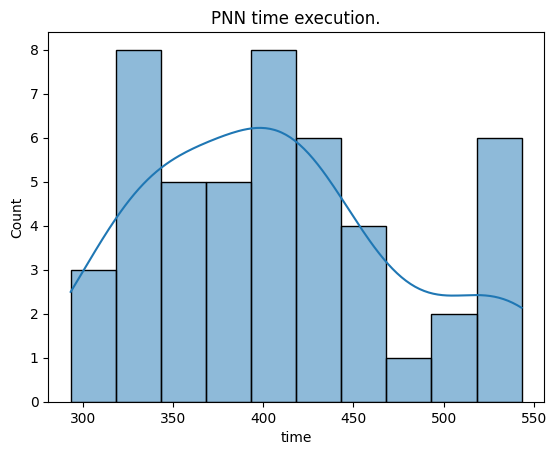

In [61]:
sns.histplot(df_final2['time'], kde=True, bins=10)
plt.title('PNN time execution.');

In [69]:
mean_time_of_execution2 = df_final2.time.mean()

In [70]:
print(f'Each batch of 5 population took, in average {mean_time_of_execution2:.2f} seconds.')

Each batch of 5 population took, in average 406.95 seconds.


The parallel execution approach paid off. By running the population individually, each individual run was taking roughly 120 seconds to complete.

In [71]:
print(f'The improvement by running in parallel was {(1- (mean_time_of_execution2 / (5*120)))*100:.2f}%')

The improvement by running in parallel was 32.17%


In [72]:
print(f'The estimated total time of execution (for 50 runs) was: {mean_time_of_execution2*10:.2f} seconds.')

The estimated total time of execution (for 50 runs) was: 4069.54 seconds.


### Loop time

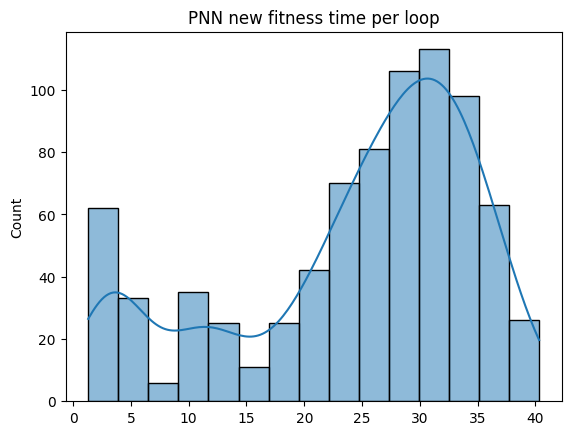

In [73]:
t2 = []
df_final2.loop_time.apply(lambda x: t2.extend(x))

sns.histplot(t2, kde=True)
plt.title('PNN new fitness time per loop');

In [74]:
loop_time_mean2 = df_final2.loop_time.apply(lambda x: np.mean(x)).mean()

In [75]:
print(f'The mean time of execution of each generation loop was {loop_time_mean2:.2f} seconds.')

The mean time of execution of each generation loop was 25.51 seconds.


In [76]:
loop_time_std2 = df_final2.loop_time.apply(lambda x: np.std(x)).mean()

In [77]:
print(f'The standard deviation of time of execution of the generation loop was {loop_time_std2:.2f} seconds.')

The standard deviation of time of execution of the generation loop was 8.41 seconds.


### Number of generations to converge

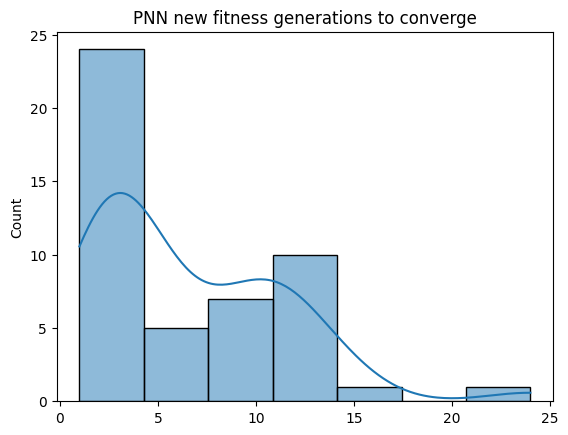

In [78]:
g2 = []
df_final2.loop_time.apply(lambda x: g2.append(len(x) - 10))

sns.histplot(g2, kde=True)
plt.title('PNN new fitness generations to converge');

In [79]:
print(f'The algorithm took, in average, {df_final2.loop_time.apply(lambda x: len(x) - 10).mean():.0f} generations to converge.')

The algorithm took, in average, 7 generations to converge.


## Metrics

### Best solution found

In [80]:
best2 = df_final2[df_final2.inertia == df_final2.inertia.min()]
best_inertia2 = best2.inertia.iloc[0]
best_centroids2 = best2.best.iloc[0]
best_generations_to_converge2 = best2.loop_time.apply(lambda x: len(x) - 10).iloc[0]

In [81]:
print(f'The best inertia was: {best_inertia2:.2f}.')

The best inertia was: 24512.87.


In [82]:
print(f'The best run took {best_generations_to_converge2} generations to converge.')

The best run took 6 generations to converge.


In [83]:
get_cluster_distribution(best_centroids2, data)

labels
0    0.273498
1    0.260625
2    0.242122
3    0.223756
Name: proportion, dtype: float64

In [84]:
best_centroids2

array([[0.57043338, 0.60954145, 0.5551824 , 0.3596791 , 0.12693881,
        0.51070642, 0.67459688],
       [0.5095549 , 0.5940657 , 0.53787377, 0.76836387, 0.16362234,
        0.66130682, 0.6943178 ],
       [0.48235228, 0.34163122, 0.43767504, 0.27302969, 0.86159038,
        0.40760757, 0.20732386],
       [0.48235228, 0.34163122, 0.43767504, 0.27302969, 0.86159038,
        0.40760757, 0.20732386]])

<font color='red' size=4>Interestingly enough, this solution gave us 3 centroids!</font>

#### KMeans solution with 3 centroids

In [149]:
km = KMeans(3)
km.fit(data)
km.inertia_

27807.002462487482

### Dispersion metrics

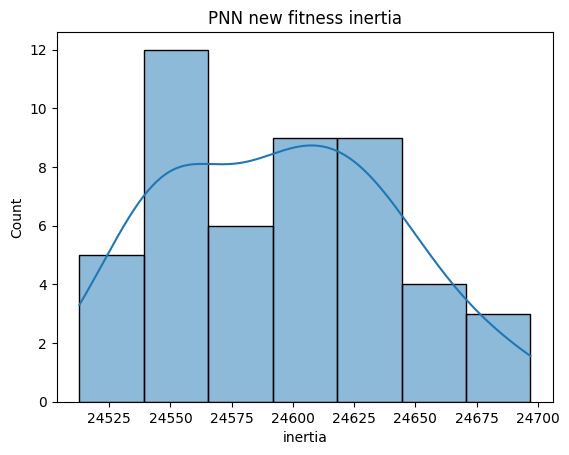

In [85]:
sns.histplot(df_final2.inertia, kde=True)
plt.title('PNN new fitness inertia');

In [86]:
worst_inertia2 = df_final2.inertia.max()
mean_inertia2 = df_final2.inertia.mean()
std_inertia2 = df_final2.inertia.std()

In [87]:
print(f'The worst result was: {worst_inertia2:.2f}.')
print(f'The mean inertia was: {mean_inertia2:.2f}.')
print(f'The inertia standard deviation was: {std_inertia2:.2f}.')

The worst result was: 24696.95.
The mean inertia was: 24594.52.
The inertia standard deviation was: 46.51.


# Cluster visualization

In [88]:
kmeans_pp_centroids = [[0.40123645, 0.46631013, 0.51742167, 0.70974094, 0.78890153, 0.60297059, 0.38546503],
                       [0.5693395 , 0.61023813, 0.55559291, 0.36617624, 0.12735113, 0.51176878, 0.67674371],
                       [0.48156959, 0.33966241, 0.43694748, 0.27543574, 0.86066963, 0.41195281, 0.20622863],
                       [0.50769913, 0.59078998, 0.53620261, 0.77215188, 0.17187666, 0.66374367, 0.68813925]]

kmeans_random_centroids = [[0.50766739, 0.59063897, 0.53624108, 0.7712757 , 0.17164255, 0.66336827, 0.68789471],
                           [0.48152898, 0.33997377, 0.4371579 , 0.27622923, 0.86029753, 0.41255589, 0.20659026],
                           [0.5695856 , 0.61027317, 0.55560089, 0.36529747, 0.12763039, 0.51149081, 0.676579  ],
                           [0.4008946 , 0.46659056, 0.51754018, 0.71091161, 0.78940757, 0.60320396, 0.3858986 ]]

PNN_centroids = [[0.56977874, 0.60622711, 0.55121396, 0.35920552, 0.12939079, 0.51391685, 0.66755455],
                 [0.51063327, 0.59817511, 0.53989838, 0.76862631, 0.16313677, 0.65843156, 0.70148711],
                 [0.40361735, 0.47195815, 0.52920241, 0.72225111, 0.76733847, 0.60911294, 0.39902535],
                 [0.48486117, 0.34432539, 0.44299391, 0.28710029, 0.86167361, 0.41389669, 0.21086879]]

PNN_nfit_centroids = [[0.57043338, 0.60954145, 0.5551824 , 0.3596791 , 0.12693881, 0.51070642, 0.67459688],
                      [0.5095549 , 0.5940657 , 0.53787377, 0.76836387, 0.16362234, 0.66130682, 0.6943178 ],
                      [0.48235228, 0.34163122, 0.43767504, 0.27302969, 0.86159038, 0.40760757, 0.20732386],
                      [0.48235228, 0.34163122, 0.43767504, 0.27302969, 0.86159038, 0.40760757, 0.20732386]]

In [99]:
km_pp_labels = KMeans(4, init=kmeans_pp_centroids, max_iter=1, n_init=1).fit_predict(data)
km_random_labels = KMeans(4, init=kmeans_random_centroids, max_iter=1, n_init=1).fit_predict(data)
PNN_labels = KMeans(4, init=PNN_centroids, max_iter=1, n_init=1).fit_predict(data)
PNN_nfit_labels = KMeans(4, init=PNN_nfit_centroids, max_iter=1, n_init=1).fit_predict(data)

In [101]:
pca_data = PCA(2).fit_transform(data)

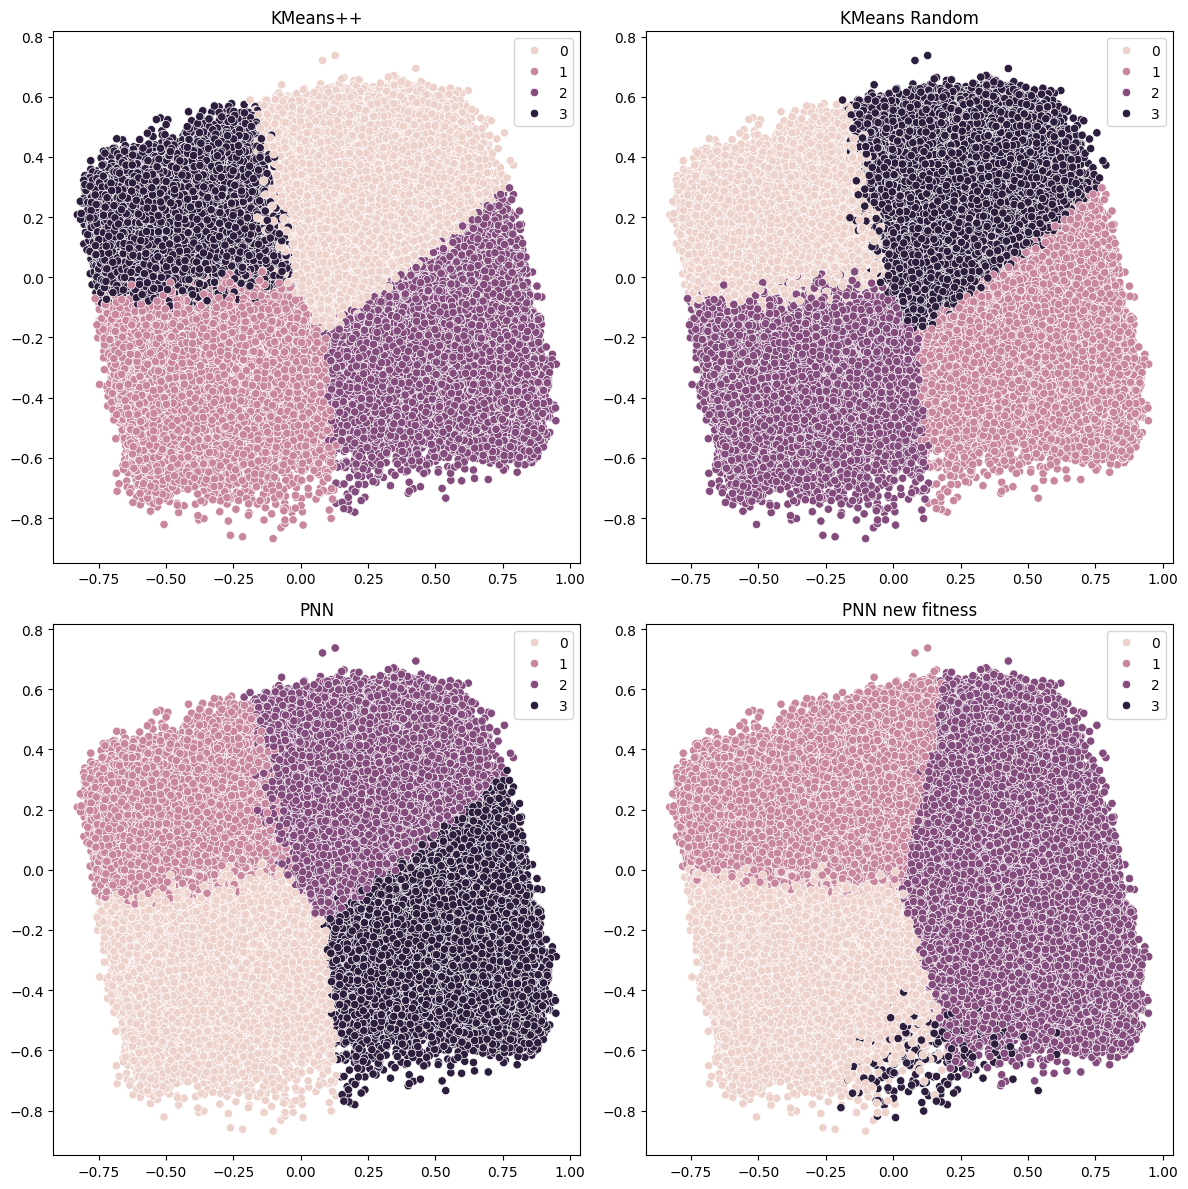

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for algo, l, ax in zip(['KMeans++', 'KMeans Random', 'PNN', 'PNN new fitness'], [km_pp_labels, km_random_labels, PNN_labels, PNN_nfit_labels], axs.flatten()):
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=l, ax=ax)
    ax.set_title(f'{algo}')

plt.tight_layout();

# Cluster examples

In [124]:
original_data = pd.read_csv('../data/clean_data/original_data.csv', index_col=0)
original_data.head()

,valence,acousticness,danceability,duration_ms,energy,liveness,loudness,tempo
1,0.963,0.732,0.819,180533.0,0.341,0.160,-12.441,60.936
3,0.165,0.967,0.275,210000.0,0.309,0.381,-9.316,100.109
4,0.253,0.957,0.418,166693.0,0.193,0.229,-10.096,101.665
5,0.196,0.579,0.697,395076.0,0.346,0.130,-12.506,119.824
6,0.406,0.996,0.518,159507.0,0.203,0.115,-10.589,66.221


In [125]:
raw_data = pd.read_csv('../data/raw_data/data.csv')
raw_data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [127]:
raw_data = raw_data.iloc[original_data.index][['artists', 'name']]
raw_data.head()

,artists,name
1,['Dennis Day'],Clancy Lowered the Boom
3,['Frank Parker'],Danny Boy
4,['Phil Regan'],When Irish Eyes Are Smiling
5,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,Gati Mardika
6,['John McCormack'],The Wearing of the Green


In [129]:
raw_data['km_pp'] = km_pp_labels
raw_data['km_random'] = km_random_labels
raw_data['PNN'] = PNN_labels
raw_data['PNN_nfit'] = PNN_nfit_labels

In [130]:
raw_data.head()

,artists,name,km_pp,km_random,PNN,PNN_nfit
1,['Dennis Day'],Clancy Lowered the Boom,0,3,2,2
3,['Frank Parker'],Danny Boy,2,1,3,2
4,['Phil Regan'],When Irish Eyes Are Smiling,2,1,3,2
5,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,Gati Mardika,2,1,3,2
6,['John McCormack'],The Wearing of the Green,2,1,3,2


## Recommendations by PNN

### Group 0

In [140]:
raw_data[raw_data.PNN == 0].sample(10)[['artists', 'name']]

,artists,name
38506,"['Future', 'Lil Uzi Vert']",Bust a Move
123838,['Naylo'],Tesla
36404,"['Drake', 'Lil Wayne']",Ignant Shit (feat. Lil Wayne)
18744,"['Pia Mia', 'Chris Brown', 'Tyga']",Do It Again
168905,['Twiztid'],LDLHAIBCSYWA
150439,['Monica Naranjo'],Sobreviviré
149333,['Ratt'],City to City
89395,['Hot Chip'],Boy From School
33931,['The Offspring'],All I Want
162873,"['John Carpenter', 'Alan Howarth']",He Know's Where She Is


### Group 1

In [141]:
raw_data[raw_data.PNN == 1].sample(10)[['artists', 'name']]

,artists,name
152157,['Grupo Cañaveral De Humberto Pabón'],Traicion Y Olvido
135575,['Los Tigres Del Norte'],El Ultimo Atardecer
13061,['INXS'],New Sensation
164172,['Mister Chivo'],Soy Drácula
31685,['Depeche Mode'],Master and Servant
32766,['Luis Miguel'],Inolvidable
82202,['The Meters'],Art
106972,['Beyoncé'],I Miss You
118607,['George Strait'],If You Ain't Lovin' (You Ain't Livin')
168057,['La Victoria De Mexico'],Con Cartitas


### Group 2

In [142]:
raw_data[raw_data.PNN == 2].sample(10)[['artists', 'name']]

,artists,name
157021,['Talat Mahmood'],Duniya Mein Jeena Hi Padega
60443,['Sitara'],Papiha Re Piu Ki Boli Na Bol
20220,"['Francisco Canaro', 'Agustín Irusta']",Moneda Falsa - Remasterizado
115690,['The Beach Boys'],Little Deuce Coupe
98147,"['Desmond Dekker', 'The Aces']",Rude Boy Train
144913,['Chico Buarque'],Sonho de um Carnaval
91638,['slenderbodies'],anemone
94755,"['Lata Mangeshkar', 'Mohammed Rafi']",Main Ne Kaha Babuji
81145,['Oscar Peterson Trio'],Goodbye J.D.
94408,['Трумен Капоте'],"Часть 14.3 - Другие голоса, другие комнаты"


### Group 3

In [143]:
raw_data[raw_data.PNN == 3].sample(10)[['artists', 'name']]

,artists,name
164874,['Maurane'],Sur un prélude de Bach
40542,['H.P. Lovecraft'],Capítulo 22.5 & Capítulo 23.1 - la Sombra Fuer...
59147,['Bina Chowdhury'],Mor Pathikere Bujhi Enechho
95617,['Harry Belafonte'],Lord Randall
113335,['Johnny Cash'],When I've Learned
127336,"['Giuseppe Verdi', 'Ebe Stignani', ""Orchestra ...",Aida / Act 4: L'aborrita rivale a me sfuggia
39639,['K Mullick'],Bagichay Bulbuli Tui
141579,"['Wolfgang Amadeus Mozart', 'Jascha Heifetz', ...","Sinfonia concertante in E-Flat Major, K. 364: ..."
6203,"['The Carter Sisters', 'Mother Maybelle']",Fair And Tender Ladies
7916,['Frank Sinatra'],September In The Rain - 1998 Digital Remaster


### Recommendations by PNN new fitness

### Group 0

In [144]:
raw_data[raw_data.PNN_nfit == 0].sample(10)[['artists', 'name']]

,artists,name
124812,['LOONA'],Why Not?
104356,['Pitchshifter'],Genius
104683,['Kittie'],Charlotte
49435,['Air Supply'],Keeping the Love Alive
48074,['Boz Scaggs'],Slow Dancer
122592,['Papercut Massacre'],Lose My Life
51491,"[""Guns N' Roses""]",Pretty Tied Up (The Perils Of Rock N' Roll Dec...
76248,"['Margarita Cueto', 'Carlos Mejía']",El Alma en los Labios
19681,"['Juice WRLD', 'The Weeknd']",Smile (with The Weeknd)
122439,['All Time Low'],Jasey Rae (Acoustic)


### Group 1

In [145]:
raw_data[raw_data.PNN_nfit == 1].sample(10)[['artists', 'name']]

,artists,name
98682,"['Django Reinhardt', 'Coleman Hawkins']",Crazy Rhythm
65588,['Curtis Mayfield'],No Thing on Me (Cocaine Song)
107143,['Modern Baseball'],The Weekend
89044,['Marc Anthony'],Se Esfuma Tu Amor - Salsa Version
91746,['Sabrina Carpenter'],Why
77857,['Hubert Fol'],Lubie Loo
146538,['Leo Sayer'],One Man Band - Remastered
156068,['Эрих Мария Ремарк'],Часть 230.2 - Триумфальная арка
142973,['Machito & His Orchestra'],Tea For Two
146374,['Vicente Fernández'],Hablando Claro


### Group 2

In [146]:
raw_data[raw_data.PNN_nfit == 2].sample(10)[['artists', 'name']]

,artists,name
21719,"['Francisco Canaro', 'Carlos Galán']",Rosa Peregrina - Remasterizado
159976,['The Electric Prunes'],Train for Tomorrow
156156,['Трумен Капоте'],"Часть 11.4 - Другие голоса, другие комнаты"
107920,['Birdtalker'],My Lover
81050,['Homesick James'],Homesick's Blues
128767,['Etta Jones'],Something To Remember You By
143022,['Art Lund'],"Joey, Joey, Joey (From ""The Most Happy Fella"")"
23095,"['Frédéric Chopin', 'Claudio Arrau']","24 Préludes, Op. 28: Prélude No. 1 in C Major"
144616,"['Johann Sebastian Bach', 'Glenn Gould']","Invention No. 2 in C Minor, BWV 773 - Remastered"
169727,['J Dilla'],Yesterday


### Group 3

In [147]:
raw_data[raw_data.PNN_nfit == 3].sample(10)[['artists', 'name']]

,artists,name
77426,['Эрих Мария Ремарк'],Часть 214.4 - Триумфальная арка
4254,['Alfred Newman'],Unused Cue #3 - From “The Song Of Bernadette”
119260,['Randy Edelman'],The Courier
8828,['Otis Redding'],Try a Little Tenderness
86054,['Mötley Crüe'],T.n.T. (Terror 'n Tinseltown)
42313,['Эрих Мария Ремарк'],Часть 166.2 - Триумфальная арка
381,['Hykoski Studios'],Long Live Love Life
166409,"['Richard Strauss', 'London Philharmonic Orche...",Also Sprach Zarathustra Op.30: Einleitung (Ope...
122846,"['Hans Zimmer', 'Geoff Zanelli', 'Blake Neely']","Honor (Main Title Theme from ""The Pacific"")"
168364,['Nicholas Hooper'],Farewell Aragog
